In [1]:
import tensorflow as tf
import tensorflow.keras as keras

# Load Fashion MNIST Data

In [2]:
fashion_mnist = keras.datasets.fashion_mnist

(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

X_train_full.shape

X_train_full.dtype

X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0

y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# Build Keras Model

In [3]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28])) # no need for batch size, only instance size
model.add(keras.layers.Dense(300, activation='relu')) # only output dim required in a Sequential model
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


1. 每个张量都有一个`shape`，n阶张量的`shape`由n个数确定。
1. 整个训练集可以视为一个张量，默认其第一个维度为`batch_size`，剩余的维度要和模型在参数中明说的`input_shape`匹配。
1. 尽管没有在参数中明说，任意层的`input_shape`和`output_shape`的第一维其实是`batch_size`
1. 在一个`Sequential`模型中，`Dense`层的`input_shape`默认等于上一层的`output_shape`，`output_shape`等于`(output_dim)`
1. `Dense`默认输出一个形状为`(param1, )`的张量(实际上是`(batch_size, param1)`)

#### Access Layer
可以直接获取每一个层的参数

In [11]:
hidden1 = model.get_layer('dense')

In [12]:
weights, biases = hidden1.get_weights()

与`Layer`不同，`weight`的形状并不默认第一层为`batch_size`，它的形状就是这个`Layer`在参数中明说的`input_shape`(必然是1阶）$\times$ `output_shape`(必然为1阶）

In [13]:
weights.shape

(784, 300)

`biases`必然是一阶张量。注意，(300, 1)表示的是二阶张量

In [14]:
biases.shape

(300,)

#### Compile Model

In [15]:
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [16]:
history = model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/2
55000/55000 [==============================] - 21s 388us/sample - loss: 0.7062 - accuracy: 0.7663 - val_loss: 0.5002 - val_accuracy: 0.8316
Epoch 2/2
55000/55000 [==============================] - 17s 316us/sample - loss: 0.4876 - accuracy: 0.8297 - val_loss: 0.4551 - val_accuracy: 0.8438


`history`对象保存了模型训练过程中的所有有用信息

In [21]:
history.history

{'loss': [0.5382988056269559, 0.4648917663704265],
 'accuracy': [0.81487274, 0.83681816],
 'val_loss': [0.49241161065101624, 0.4352308737039566],
 'val_accuracy': [0.8332, 0.854]}

In [22]:
history.params

{'batch_size': 32,
 'epochs': 2,
 'steps': 1719,
 'samples': 55000,
 'verbose': 0,
 'do_validation': True,
 'metrics': ['loss', 'accuracy', 'val_loss', 'val_accuracy']}

In [23]:
history.epoch

[0, 1]

`evaluate`方法可以计算模型在测试集上的`loss`和`accuracy`（as specified when you compile the model)

In [25]:
model.evaluate(X_test, y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[79.30101196289063, 0.8069]

# 回归模型
`train_test_split`按行分裂数据，返回四个信号，顺序为`param1*p, param1*(1-p), param2*p, param2*(1-p)`。注意要使用在训练集上拟合的`scaler`来scale测试集和验证集上的feature.

In [2]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [19]:
X_train_full.shape

(15480, 8)

In [20]:
housing.data.shape

(20640, 8)

由于数据噪声太大，所以模型不能太复杂，所以只用一个隐含层

In [12]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation='relu', input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])

由于第一个`Dense`层没有上一层，所以需要明确指定`input_shape`。注意，`Dense`层的`input_shape`必须与训练集（视为一个张量）的第`1`到最后一维所形成的形状一致。

In [22]:
model.compile(loss="mean_squared_error", optimizer="sgd")
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 2s 189us/sample - loss: 0.7594 - val_loss: 0.7072
Epoch 2/20
11610/11610 [==============================] - 1s 109us/sample - loss: 0.8162 - val_loss: 0.6171
Epoch 3/20
11610/11610 [==============================] - 1s 103us/sample - loss: 0.6974 - val_loss: 0.5438
Epoch 4/20
11610/11610 [==============================] - 1s 103us/sample - loss: 0.4528 - val_loss: 0.4230
Epoch 5/20
11610/11610 [==============================] - 1s 121us/sample - loss: 0.4193 - val_loss: 0.4122
Epoch 6/20
11610/11610 [==============================] - 2s 136us/sample - loss: 0.4061 - val_loss: 0.3955
Epoch 7/20
11610/11610 [==============================] - 1s 121us/sample - loss: 0.3962 - val_loss: 0.3937
Epoch 8/20
11610/11610 [==============================] - 1s 93us/sample - loss: 0.3896 - val_loss: 0.3905
Epoch 9/20
11610/11610 [==============================] - 2s 133us/sample - loss: 0.3843

# Function API

首先搭建 Deep&Wide 模型。

搭建输入层，同样，注意`Input`的`shape`应该等于训练集（视为一个张量）的第`1`到最后一维所形成的形状。

In [24]:
input_ = keras.layers.Input(shape=X_train.shape[1:])

Sequential API默认每个单元是按照在代码中的出现顺序连接的，而Functional API需要指定连接方式，所以后面的层都需要指定上一层是哪个

In [25]:
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.Concatenate()([input_, hidden2]) # takes a list of Layers
output = keras.layers.Dense(1)(concat)

同样地，model也必须指明输入和输出是谁

In [26]:
model = keras.Model(inputs=[input_], outputs=[output]) # both are list of Layers

上述模型架构为：
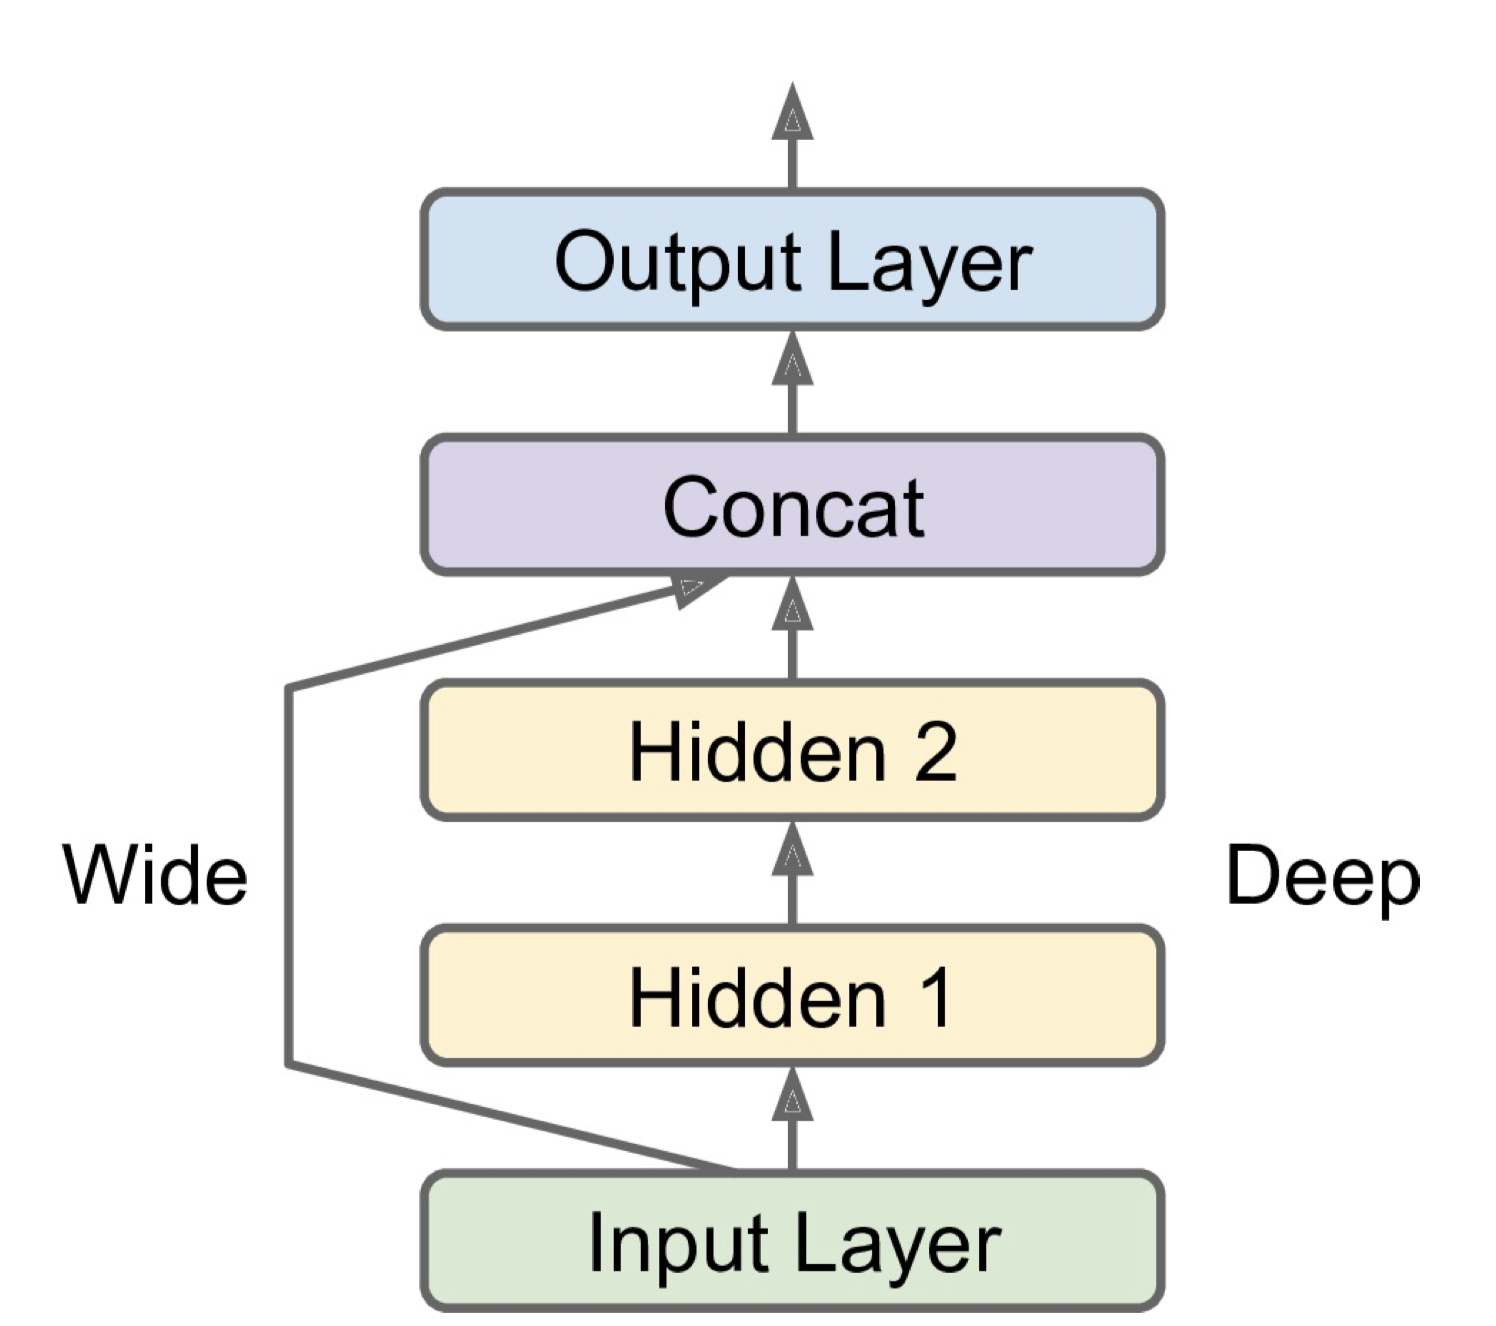
也可以定义这种架构
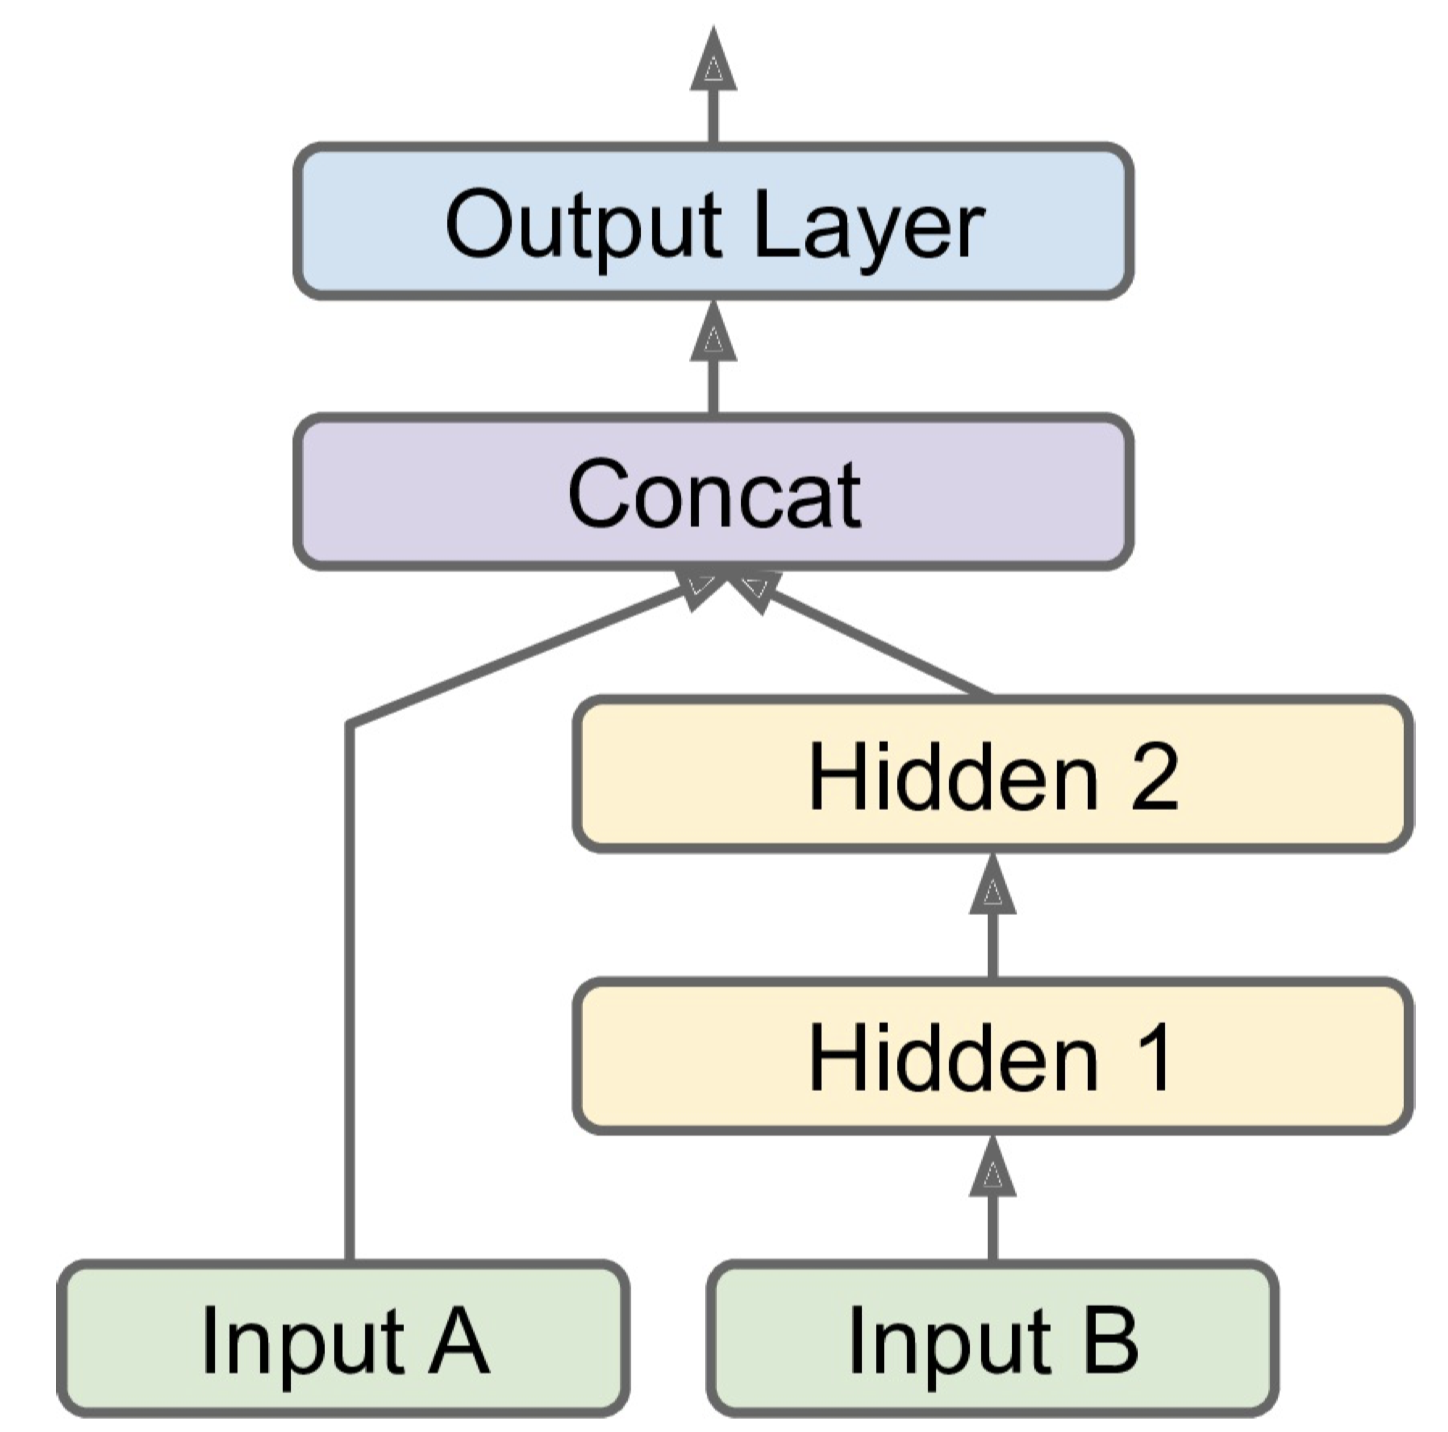

假设特征0到4进入input A, 特征2到7进入input B（可以有重叠）：

In [3]:
input_A = keras.layers.Input(shape=[5], name="wide_input") # 表示维度为5的一阶张量，name it because it's important
input_B = keras.layers.Input(shape=[6], name="deep_input") # 维度为6的一阶张量
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.Model(inputs=[input_A, input_B], outputs=[output]) # could be dict with name as key

此时，验证集应该是`((inputA, inputB), output)`的格式，测试集亦然

In [4]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]

X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]

X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]

X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit((X_train_A, X_train_B), y_train, epochs=20, validation_data=((X_valid_A, X_valid_B), y_valid))
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 11s 975us/sample - loss: 1.9718 - val_loss: 1.0262
Epoch 2/20
11610/11610 [==============================] - 6s 549us/sample - loss: 0.8313 - val_loss: 0.8128
Epoch 3/20
11610/11610 [==============================] - 8s 703us/sample - loss: 0.7240 - val_loss: 0.7289
Epoch 4/20
11610/11610 [==============================] - 9s 805us/sample - loss: 0.6720 - val_loss: 0.6816
Epoch 5/20
11610/11610 [==============================] - 14s 1ms/sample - loss: 0.6383 - val_loss: 0.6482
Epoch 6/20
11610/11610 [==============================] - 8s 684us/sample - loss: 0.6125 - val_loss: 0.6223
Epoch 7/20
11610/11610 [==============================] - 11s 984us/sample - loss: 0.5919 - val_loss: 0.6016
Epoch 8/20
11610/11610 [==============================] - 11s 976us/sample - loss: 0.5729 - val_loss: 0.5837
Epoch 9/20
11610/11610 [==============================] - 6s 549us/sample - loss: 0.5

注意`keras.Model`的`outputs`参数是一个`list`，这意味着可以有多个输出层，此时需要给每个输出层定义一个损失函数，同时还可以指定每个损失函数的权重

In [5]:
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)
model = keras.Model(inputs=[input_A, input_B], outputs=[output, aux_output])

In [6]:
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer="sgd") # loss也是一个list

In [7]:
history = model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=20, validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 4s 322us/sample - loss: 0.7011 - main_output_loss: 0.5742 - aux_output_loss: 1.8424 - val_loss: 0.5745 - val_main_output_loss: 0.5198 - val_aux_output_loss: 1.0677
Epoch 2/20
11610/11610 [==============================] - 6s 484us/sample - loss: 0.5073 - main_output_loss: 0.4572 - aux_output_loss: 0.9590 - val_loss: 0.5820 - val_main_output_loss: 0.5385 - val_aux_output_loss: 0.9739
Epoch 3/20
11610/11610 [==============================] - 8s 686us/sample - loss: 0.4690 - main_output_loss: 0.4298 - aux_output_loss: 0.8222 - val_loss: 0.4808 - val_main_output_loss: 0.4457 - val_aux_output_loss: 0.7981
Epoch 4/20
11610/11610 [==============================] - 12s 1ms/sample - loss: 0.4407 - main_output_loss: 0.4100 - aux_output_loss: 0.7171 - val_loss: 0.4722 - val_main_output_loss: 0.4440 - val_aux_output_loss: 0.7269
Epoch 5/20
11610/11610 [==============================] - 6s 529

综上可以看到，无论输入、输出还是验证集，如果有多个都是用一个list来表示

# Subclassing API

在constructor中建立一些层，在`call`方法中定义层之间的连接方式

注意到，keras.models是一个module，而keras.Model是一个对象。这个对象居然不在这个模块中，确实很奇怪。

In [24]:
class WideAndDeepModel(keras.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs) # handles standard args (e.g., name) 
        self.hidden1 = keras.layers.Dense(units, activation=activation) 
        self.hidden2 = keras.layers.Dense(units, activation=activation) 
        self.main_output = keras.layers.Dense(1) 
        self.aux_output = keras.layers.Dense(1)

    def call(self, inputs):
        input_A, input_B = inputs # inputs应该是An iterable with two first-class components
        hidden1 = self.hidden1(input_B) 
        hidden2 = self.hidden2(hidden1) 
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

model = WideAndDeepModel()

# Using Callbacks

所谓"callback"，就是指一个可以和调用者交互的被调用者。

`fit`方法接受一个`callbacks`参数，它是一个list of callbacks，其中的每个元素定义模型训练时的一种行为。下述callback在每个epoch结尾存储模型。

一般来说，`ModelCheckpoint`是用来防止计算机崩溃造成模型训练进度丢失的。

In [ ]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5")
history = model.fit(X_train, y_train, epochs=10, callbacks=[checkpoint_cb])

下面这样定义的callback只保存整个训练过程中最好的参数。要使用这种callback，必须要有验证集。

In [ ]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), callbacks=[checkpoint_cb])

`EarlyStopping`这种callback不止存储最好的模型，而且当模型经过10次迭代还在验证集上没有提升时，会中断训练：

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
# 不需要指定存储模型名，这个callback会自动保存

将上述两种callback结合，就是定义了模型训练过程中的“防止系统崩溃而做备份”和“没提升就停止训练并保存最佳模型”两种行为：

In [ ]:
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid), callbacks=[checkpoint_cb, early_stopping_cb])

要想自定义训练时行为，只需要继承`keras.callbacks.Callback`对象，然后implement某些方法，其中每个方法定义训练时的某个时刻的行为。

# 调参

可以使用sklearn自带的调参类

In [ ]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

这里，`build_model`创建了一个keras model，而wrapper的本质就是建立从keras model类到sklearn model类的方法的一一映射——而我们知道，只要两个类的方法一样，他们其实就是同一种东西（即使它们的底层实现完全不同）

一些神经网络调参经验：
1. 与其从简单的模型开始，逐渐增大模型复杂度知道开始过拟合，不如一开始就选择复杂模型，然后用early stopping
1. 与其增加神经元，不如增加网络层数

In [2]:
from sklearn.model_selection import train_test_split

/home/quqi/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [3]:
X = [[1,2],[3,4],[5,6]]

In [4]:
train_test_split(X, )

[[[3, 4], [1, 2]], [[5, 6]]]